In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [4]:
# SDOF Transient Response (ISO 18431-4)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta):

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [5]:
## SRS (ISO 18431-4)
def srs_iso(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_ISO(th,dt,ft[i],dr)));
    return ft,rs;

In [6]:
def fileI(filename):
    tmp = []
    f = open(filename,'r');
    lines = f.readlines()
    for line in lines:
        tmp.append(line);
    out=np.zeros([len(tmp),5]);
    for i in range(len(out)):
        out[i,:] = np.array(tmp[i].split()).astype(np.float)
    return out;

C:\Users\OWNER\AppData\Local\Temp/ipykernel_14820/2418606376.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out[i,:] = np.array(tmp[i].split()).astype(np.float)


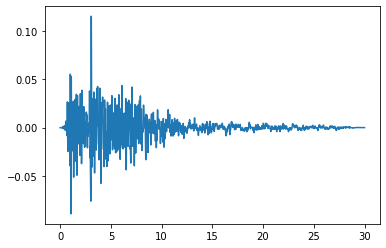

In [7]:
# Read Acc. th
data = fileI('RSN454_MORGAN_GIL067.AT2');
th = np.zeros(len(data)*5);
idx = 0;
for i in range(len(data)):
    for j in range(5):
        th[idx] = data[i,j];
        idx += 1;
dt = 0.005;
N = len(th);
tmax = dt*N;
time = np.arange(0,tmax,dt);
plt.plot(time,th);

In [418]:
Nt = len(th); tf = max(time); df = 1/tf;
fmax = df*Nt/2; Nf = int(Nt/2);
freq_table = np.arange(df,fmax+df,df);

In [421]:
freq,rs = srs_iso(freq_table,th,dr=0.05,dt=dt)

In [422]:
# RG 1.60
ft = np.array([0.10,  2.50, 9.00, 33.0, 100.0]);  # frequency table
rt = np.array([0.07,  3.13, 2.61,  1.0,   1.0]);  # response spectrum table

In [423]:
# log-log interp
freq_spec = np.copy(freq_table);
resp_spec = 10**np.interp(np.log10(freq_spec),np.log10(ft),np.log10(rt));
resp_spec_u = resp_spec*1.3;
resp_spec_l = resp_spec/1.1;

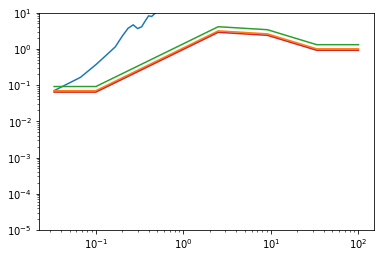

In [424]:
plt.loglog(freq,rs);
plt.loglog(freq_spec,resp_spec);
plt.loglog(freq_spec,resp_spec_u);
plt.loglog(freq_spec,resp_spec_l);
plt.ylim(1e-5,1e1);

In [425]:
th *= max(resp_spec/rs);

In [426]:
freq,rs = srs_iso(freq_table,th,dr=0.05,dt=dt)

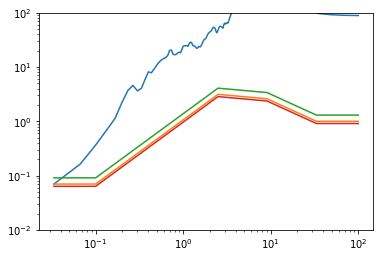

In [427]:
plt.loglog(freq,rs);
plt.loglog(freq_spec,resp_spec);
plt.loglog(freq_spec,resp_spec_u);
plt.loglog(freq_spec,resp_spec_l);
plt.ylim(1e-2,1e2);

In [506]:
def Psi(m,n,k,t):
    out = (np.exp(1j*2*n*np.pi*(t-k/(n-m)))-np.exp(1j*2*m*np.pi*(t-k/(n-m)))) / (1j*2*(n-m)*np.pi*(t-k/(n-m)));
    np.nan_to_num(out, copy=False)
    return out;

In [507]:
def a(m,n,k,time,th):
    return sum(th*Psi(m,n,k,time/tf));

In [508]:
zeta=0.05;
## Step 1
R = np.zeros(len(rs));
for i in range(len(rs)):
    R[i] = min(rs[i]/resp_spec_l[i],resp_spec_u[i]/rs[i]);
j_worst = np.argmin(R); f_worst = freq[j_worst]; 
resp = SDOF_ISO(th,dt,f_worst,zeta); tau_worst = time[np.argmax(abs(resp))];

In [509]:
## Step 2
Nf_min = 30;  # 임의 설정
B = (Nf_min-1)*df;
m = j_worst-int(Nf_min/2)
n = j_worst+int(Nf_min/2)
fm = freq[m]
fn = freq[n]

In [510]:
## Step 3
dtau = 3/(zeta*f_worst*2*np.pi);
k1 = int(((tau_worst-dtau)/tf)*(n-m));
k2 = int((tau_worst/tf)*(n-m))+1;
new_th = np.zeros(len(th));
for j in range(len(time)):
    t = time[j];
    out = 0;
    for k in range(k1,k2):
        out += 2*np.real(a(m,n,k,time,th)*Psi(m,n,k,t));
    new_th[j] = out;

C:\Users\OWNER\AppData\Local\Temp/ipykernel_14820/1258879034.py:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  out = (np.exp(1j*2*n*np.pi*(t-k/(n-m)))-np.exp(1j*2*m*np.pi*(t-k/(n-m)))) / (1j*2*(n-m)*np.pi*(t-k/(n-m)));


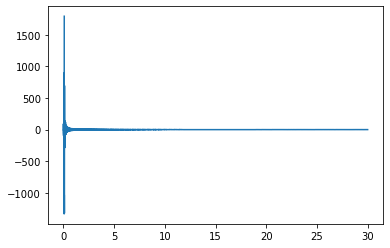

In [511]:
plt.plot(time,new_th);

In [512]:
## Step 4
resp1 = SDOF_ISO(new_th,dt,f_worst,zeta);
Pl = resp*resp1;
lmax = np.argmax(Pl);

In [513]:
## Step 5
if rs[j_worst] < resp_spec[j_worst]:
    AT = resp_spec_l*1.05;
else:
    AT = resp_spec_u*0.95;
D = AT*(1/f_worst)**2;
alpha = (D-resp[lmax]) / resp1[lmax];

In [514]:
alpha

array([nan, nan, nan, ..., nan, nan, nan])

In [523]:
Psi(m,n,k1,t=time[20])

(-8.834874115176434e-16-6.537806845230561e-16j)

In [524]:
D

array([0.00058703, 0.00058703, 0.00058715, ..., 0.00838614, 0.00838614,
       0.00838614])

In [525]:
resp[lmax]

-0.05746592386409422

In [526]:
resp1[lmax]

nan

In [531]:
np.nan_to_num(resp1,copy=False)

array([1.66470308e-13, 1.38600204e-01, 4.38245690e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [532]:
resp1[lmax]

0.0